In [1]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad
from autograd.optimizers import sgd

import matplotlib.pyplot as plot

from emcee import EnsembleSampler, PTSampler
from collections import OrderedDict

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
npr.seed(1234)

In [4]:
n_dim = 1
n_hid = 10

bias = npr.randn()
noise_std = 1.
tra_ratio = 0.5
n_samples = 100

x_ = 4. * npr.rand(n_samples) - 2.
y_ = numpy.sin(10. * x_) + x_**2

y_ += bias

n_tra = numpy.round(n_samples * tra_ratio).astype('int')
x_tra, y_tra = x_[:n_tra], y_[:n_tra]
x_tes, y_tes = x_[:n_tra], y_[:n_tra]

y_tra = y_tra + noise_std * npr.randn(*y_tra.shape)

In [5]:
def init_params(n_dim, n_hid, scale=1.):
    w1 = scale * npr.randn(n_dim, n_hid)
    b1 = scale * npr.randn(n_hid)
    w2 = scale * npr.randn(n_hid)
    b2 = scale * npr.randn(1)
    
    params = OrderedDict({'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2})
    shapes = [(nn,pp.shape) for nn, pp in params.items()]
    
    return params, shapes

def flatten(p):
    return numpy.concatenate([pp.flatten() for nn, pp in p.items()])

def unflatten(p, shapes):
    params = OrderedDict()
    idx = 0
    for shp in shapes:
        nn = shp[0]
        i1 = idx + numpy.prod(shp[1])
        params[nn] = p[idx:i1].reshape(shp[1])
        idx = i1
    return params

In [6]:
def tanh(a):
    return numpy.tanh(a)

In [7]:
def mlp(x, p):   
    x = x[:, None] if len(x.shape) < 2 else x
    
    h = tanh(numpy.dot(x, p['w1']) + p['b1'][None,:])
    y = numpy.dot(h, p['w2']) + p['b2']

    return y

In [8]:
def mlp_dist(y, x, p, avg=False):
    y_ = mlp(x, p)
    
    d = ((y - y_) ** 2)
    
    if not avg:
        return d
    return numpy.mean(d)

In [9]:
def logprior(p):        
    if numpy.sum(numpy.abs(p) > 10.) == 0:
        return 0.0
    return -numpy.inf

def loglik(p, x, y, shapes):
    return -mlp_dist(y, x, p).sum()

def logp(p, x, y, shapes):
    p_ = unflatten(p, shapes)
    return loglik(p_, x, y, shapes) + logprior(p)

In [10]:
from multiprocess import Pool

In [11]:
def predict(xx, n=20, n_chains=4, interval=10, burnin=100):
    
    # importance sampling
    p0 = [init_params(n_dim, n_hid) for ii in xrange(n_chains)]
    shapes = p0[0][1]
    p_flater = [flatten(p[0]) for p in p0]
    p_params = numpy.concatenate([pf[None,:] for pf in p_flater], 0)
    sampler = EnsembleSampler(n_chains, p_params.shape[1], logp, a=2.0, 
                              args=[x_tra, y_tra, shapes], threads=3, live_dangerously=True)
    pos, _, _ = sampler.run_mcmc(p_params, burnin)
    sampler.reset()
    pos, _, _ = sampler.run_mcmc(pos, n * interval)
    
    ws_ = sampler.chain[:,::interval,:].reshape(-1, p_params.shape[1])
        
    #print ws_[:,-5:]
    #return 0., 0., 0.

    p1_params = [unflatten(ws_[ii], shapes) for ii in xrange(n)]
   
    p = Pool(n_chains)
    tpred = p.map(lambda w_: mlp(xx, w_), p1_params)
    p.close()

    preds = numpy.concatenate([tp[:, None] for tp in tpred], 1)
    wpred = numpy.mean(preds, -1)
    wvar = numpy.var(preds, -1)
    
    return wpred, wvar, p1_params

In [21]:
tra_er = ((predict(x_tra, n=60, n_chains=64)[0] - y_tra) ** 2).mean()
tes_er = ((predict(x_tes, n=60, n_chains=64)[0] - y_tes) ** 2).mean()

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 1.30055361309, Test error rate 0.64633536273


In [22]:
# visualize data 
def vis_data(x, y, c='r'):
    if y is None: 
        y = [0] * len(x)
    plot.plot(x, y, 'x', markerfacecolor='none', markeredgecolor=c)
    plot.grid('on')

In [23]:
def vis_pred(typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_, y_var, _ = predict(x_, n=60, n_chains=64)
    
    plt1, = plot.plot(x_, y_, typ)
    
    plot.fill(numpy.concatenate([x_, x_[::-1]]),
         numpy.concatenate([y_ - 1.9600 * numpy.sqrt(y_var),
                        (y_ + 1.9600 * numpy.sqrt(y_var))[::-1]]),
         alpha=.5, fc='b', ec='None')


    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    return plt1

<IPython.core.display.Javascript object>


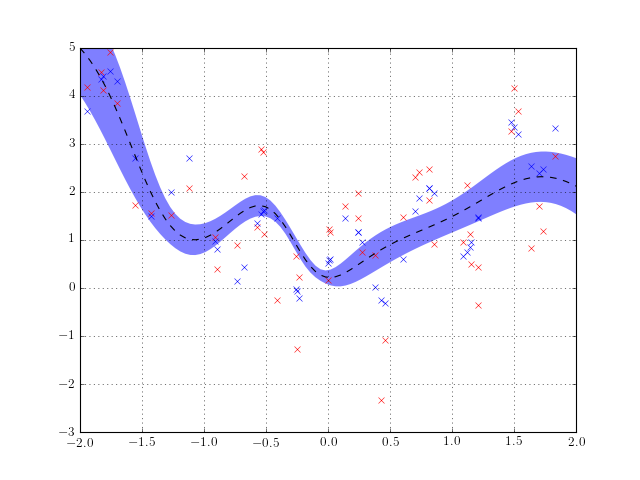

In [24]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_data(x_tes, y_tes, c='b')

#plt0 = vis_pred(params0, 'k-.')
plt1 = vis_pred('k--')
#plot.legend([plt0, plt1], [
#        'Initial',
#        'Final'],
#           loc='best')

plot.show()

In [26]:
plot.savefig('../figures/bayes_linreg_mlp.pdf', dpi=100)